In [1]:
import sys

In [2]:
import torch

In [3]:
import importlib
from tensorboardX import SummaryWriter
import torch.nn.utils.rnn as rnn_utils
import pickle
import tqdm
import os

In [4]:
import torch.nn as nn

In [5]:
sys.path.append(".")

In [6]:
from dataUtils import *

load glove finished


In [7]:
import json

In [8]:
from collections import deque

In [9]:
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

### 数据集分析

In [9]:
with open("../../config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)

In [10]:
load_data_fast()

max_sent: 308 ,  max_seq_len: 346
5802 data loaded


In [10]:
load_data("/home/hadoop/pheme-rnr-dataset/", FLAGS)

KeyboardInterrupt: 

In [11]:
del data
del data_ID
del data_y
del data_len
from dataUtils import data
from dataUtils import data_ID
from dataUtils import data_y
from dataUtils import data_len

In [12]:
import time

In [13]:
t_hour = [(data[data_ID[i]]['created_at'][-1]-data[data_ID[i]]['created_at'][0])/3600.0 for i in range(len(data_ID))] 

In [14]:
import seaborn as sns

In [41]:
def plot_hist(x_tuples, bins, xlabel, ylabel, legends, title):
    colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0,), (0, 0, 1)]
    def normfun(x,mu,sigma):
        pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
        return pdf
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
#     plt.xlim(0, 200)
    for i in range(len(x_tuples)):
        sns.distplot(x_tuples[i], bins=bins, rug=False, kde=True, hist=True, norm_hist=True, label=legends[i], hist_kws={"histtype": "step", "linewidth": 2,
        "alpha": 1}, kde_kws={"color": colors[0], "lw": 0, "label": ""})

In [16]:
import matplotlib.pyplot as plt

In [28]:
len(t_hour), max(t_hour), min(t_hour)

(5802, 728.7561111111111, 0.0)

In [38]:
max(data_len), min(data_len)

(346, 1)

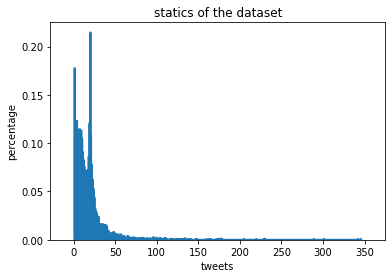

In [42]:
plot_hist([data_len], 1000, "tweets", "percentage", [""], "statics of the dataset")

### 切割数据集

In [43]:
len(data_ID), len(data_y), len(data_len)

(5802, 5802, 5802)

In [52]:
new_y =[]
new_ID = []
new_len = []

for l, ID, y in zip(data_len, data_ID, data_y):
    if l > 5:
        new_len.append(l)
        new_ID.append(ID)
        new_y.append(y)

In [53]:
len(new_ID), len(new_len), len(new_y)

(4604, 4604, 4604)

In [62]:
with open('data/data_dict.txt', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
np.save("data/data_ID.npy", np.array(new_ID)[:-500])
np.save("data/data_len.npy", np.array(new_len)[:-500])
np.save("data/data_y.npy", np.array(new_y)[:-500])

np.save("data/test_data_ID.npy", np.array(new_ID)[-500:])
np.save("data/test_data_len.npy", np.array(new_len)[-500:])
np.save("data/test_data_y.npy", np.array(new_y)[-500:])

### 模型训练与测试

In [10]:

class LayerNormLSTMCell(nn.LSTMCell):
    def __init__(self, input_size, hidden_size, dropout=0.0, bias=True, use_layer_norm=True):
        super().__init__(input_size, hidden_size, bias)
        self.use_layer_norm = use_layer_norm
        if self.use_layer_norm:
            self.ln_ih = nn.LayerNorm(4 * hidden_size)
            self.ln_hh = nn.LayerNorm(4 * hidden_size)
            self.ln_ho = nn.LayerNorm(hidden_size)
        # DropConnect on the recurrent hidden to hidden weight
        self.dropout = dropout

    def forward(self, input, hidden=None):
        self.check_forward_input(input)
        if hidden is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            cx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
        else:
            hx, cx = hidden
        self.check_forward_hidden(input, hx, '[0]')
        self.check_forward_hidden(input, cx, '[1]')

        weight_hh = nn.functional.dropout(self.weight_hh, p=self.dropout, training=self.training)
        if self.use_layer_norm:
            gates = self.ln_ih(F.linear(input, self.weight_ih, self.bias_ih)) \
                     + self.ln_hh(F.linear(hx, weight_hh, self.bias_hh))
        else:
            gates = F.linear(input, self.weight_ih, self.bias_ih) \
                    + F.linear(hx, weight_hh, self.bias_hh)

        i, f, c, o = gates.chunk(4, 1)
        i_ = torch.sigmoid(i)
        f_ = torch.sigmoid(f)
        c_ = torch.tanh(c)
        o_ = torch.sigmoid(o)
        cy = (f_ * cx) + (i_ * c_)
        if self.use_layer_norm:
            hy = o_ * self.ln_ho(torch.tanh(cy))
        else:
            hy = o_ * torch.tanh(cy)
        return hy, cy

class LayerNormLSTM(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 dropout=0.0,
                 weight_dropout=0.0,
                 bias=True,
                 bidirectional=False,
                 use_layer_norm=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # using variational dropout
        self.dropout = dropout
        self.bidirectional = bidirectional

        num_directions = 2 if bidirectional else 1
        self.hidden0 = nn.ModuleList([
            LayerNormLSTMCell(input_size=(input_size if layer == 0 else hidden_size * num_directions),
                              hidden_size=hidden_size, dropout=weight_dropout, bias=bias, use_layer_norm=use_layer_norm)
            for layer in range(num_layers)
        ])

        if self.bidirectional:
            self.hidden1 = nn.ModuleList([
                LayerNormLSTMCell(input_size=(input_size if layer == 0 else hidden_size * num_directions),
                                  hidden_size=hidden_size, dropout=weight_dropout, bias=bias, use_layer_norm=use_layer_norm)
                for layer in range(num_layers)
            ])

    def copy_parameters(self, rnn_old):
        for param in rnn_old.named_parameters():
            name_ = param[0].split("_")
            layer = int(name_[2].replace("l", ""))
            sub_name = "_".join(name_[:2])
            if len(name_) > 3:
                self.hidden1[layer].register_parameter(sub_name, param[1])
            else:
                self.hidden0[layer].register_parameter(sub_name, param[1])

    def forward(self, input, hidden=None, seq_lens=None):
        seq_len, batch_size, _ = input.size()
        num_directions = 2 if self.bidirectional else 1
        if hidden is None:
            hx = input.new_zeros(self.num_layers * num_directions, batch_size, self.hidden_size, requires_grad=False)
            cx = input.new_zeros(self.num_layers * num_directions, batch_size, self.hidden_size, requires_grad=False)
        else:
            hx, cx = hidden

        ht = []
        for i in range(seq_len):
            ht.append([None] * (self.num_layers * num_directions))
        ct = []
        for i in range(seq_len):
            ct.append([None] * (self.num_layers * num_directions))

        seq_len_mask = input.new_ones(batch_size, seq_len, self.hidden_size, requires_grad=False)
        if seq_lens != None:
            for i, l in enumerate(seq_lens):
                seq_len_mask[i, l:, :] = 0
        seq_len_mask = seq_len_mask.transpose(0, 1)

        if self.bidirectional:
            # if use cuda, change 'torch.LongTensor' to 'torch.cuda.LongTensor'
            indices_ = (torch.LongTensor(seq_lens) - 1).unsqueeze(1).unsqueeze(0).unsqueeze(0).repeat(
                [1, 1, 1, self.hidden_size])
            # if use cuda, change 'torch.LongTensor' to 'torch.cuda.LongTensor'
            indices_reverse = torch.LongTensor([0] * batch_size).unsqueeze(1).unsqueeze(0).unsqueeze(0).repeat(
                [1, 1, 1, self.hidden_size])
            indices = torch.cat((indices_, indices_reverse), dim=1)
            hy = []
            cy = []
            xs = input
            # Variational Dropout
            if not self.training or self.dropout == 0:
                dropout_mask = input.new_ones(self.num_layers, 2, batch_size, self.hidden_size)
            else:
                dropout_mask = input.new(self.num_layers, 2, batch_size, self.hidden_size).bernoulli_(1 - self.dropout)
                dropout_mask = Variable(dropout_mask, requires_grad=False) / (1 - self.dropout)

            for l, (layer0, layer1) in enumerate(zip(self.hidden0, self.hidden1)):
                l0, l1 = 2 * l, 2 * l + 1
                h0, c0, h1, c1 = hx[l0], cx[l0], hx[l1], cx[l1]
                for t, (x0, x1) in enumerate(zip(xs, reversed(xs))):
                    ht_, ct_ = layer0(x0, (h0, c0))
                    ht[t][l0] = ht_ * seq_len_mask[t]
                    ct[t][l0] = ct_ * seq_len_mask[t]
                    h0, c0 = ht[t][l0], ct[t][l0]
                    t = seq_len - 1 - t
                    ht_, ct_ = layer1(x1, (h1, c1))
                    ht[t][l1] = ht_ * seq_len_mask[t]
                    ct[t][l1] = ct_ * seq_len_mask[t]
                    h1, c1 = ht[t][l1], ct[t][l1]

                xs = [torch.cat((h[l0]*dropout_mask[l][0], h[l1]*dropout_mask[l][1]), dim=1) for h in ht]
                ht_temp = torch.stack([torch.stack([h[l0], h[l1]]) for h in ht])
                ct_temp = torch.stack([torch.stack([c[l0], c[l1]]) for c in ct])
                if len(hy) == 0:
                    hy = torch.stack(list(ht_temp.gather(dim=0, index=indices).squeeze(0)))
                else:
                    hy = torch.cat((hy, torch.stack(list(ht_temp.gather(dim=0, index=indices).squeeze(0)))), dim=0)
                if len(cy) == 0:
                    cy = torch.stack(list(ct_temp.gather(dim=0, index=indices).squeeze(0)))
                else:
                    cy = torch.cat((cy, torch.stack(list(ct_temp.gather(dim=0, index=indices).squeeze(0)))), dim=0)
            y  = torch.stack(xs)
        else:
            # if use cuda, change 'torch.LongTensor' to 'torch.cuda.LongTensor'
            indices = (torch.cuda.LongTensor(seq_lens) - 1).unsqueeze(1).unsqueeze(0).unsqueeze(0).repeat(
                [1, self.num_layers, 1, self.hidden_size])
            h, c = hx, cx
            # Variational Dropout
            if not self.training or self.dropout == 0:
                dropout_mask = input.new_ones(self.num_layers, batch_size, self.hidden_size)
            else:
                dropout_mask = input.new(self.num_layers, batch_size, self.hidden_size).bernoulli_(1 - self.dropout)
                dropout_mask = Variable(dropout_mask, requires_grad=False) / (1 - self.dropout)

            for t, x in enumerate(input):
                for l, layer in enumerate(self.hidden0):
                    ht_, ct_ = layer(x, (h[l], c[l]))
                    ht[t][l] = ht_ * seq_len_mask[t]
                    ct[t][l] = ct_ * seq_len_mask[t]
                    x = ht[t][l] * dropout_mask[l]
                ht[t] = torch.stack(ht[t])
                ct[t] = torch.stack(ct[t])
                h, c = ht[t], ct[t]
            y = torch.stack([h[-1]*dropout_mask[-1] for h in ht])
            hy = torch.stack(list(torch.stack(ht).gather(dim=0, index=indices).squeeze(0)))
            cy = torch.stack(list(torch.stack(ct).gather(dim=0, index=indices).squeeze(0)))

        return y, (hy, cy)

In [11]:
class RDM_Model_V1(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model_V1, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = LayerNormLSTM(word_embedding_dim, 
                                self.hidden_dim, 
                                dropout=dropout_prob
                            )

    def forward(self, input_x, seq_lens): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, emb_dim = input_x.shape
        h0 = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        c0 = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        df_outputs, (df_last_state, df_last_cell) = self.gru_model(input_x.transpose(0, 1), (h0, c0), seq_lens)
        return df_outputs.transpose(0, 1), df_last_state.transpose(0, 1), df_last_cell.transpose(0, 1)

In [12]:
class pooling_layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(pooling_layer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def forward(self, inputs, cuda=True):
        # [batchsize, max_seq_len, max_word_num, input_dim] 
#         batch_size, max_seq_len, max_word_num, input_dim = inputs.shape
#         assert(input_dim == self.input_dim)
#         t_inputs = inputs.reshape([-1, self.input_dim])
#         return self.linear(t_inputs).reshape(
            
#             [-1, max_word_num, self.output_dim]
        
#         ).max(axis=1)[0].reshape(
        
#             [-1, max_seq_len, self.output_dim]
        
#         )
        inputs_sent = [torch.cat([self.linear(sent_tensor.cuda() if cuda else sent_tensor).max(axis=0)[0].unsqueeze(0) for sent_tensor in seq]) for seq in inputs]
        seqs = torch.nn.utils.rnn.pad_sequence(inputs_sent, batch_first=True)
        return seqs

class RDM_Model(nn.Module):
    def __init__(self, word_embedding_dim, sent_embedding_dim, hidden_dim, dropout_prob):
        super(RDM_Model, self).__init__()
        self.embedding_dim = sent_embedding_dim
        self.hidden_dim = hidden_dim
        self.gru_model = nn.GRU(word_embedding_dim, 
                                self.hidden_dim, 
                                batch_first=True, 
                                dropout=dropout_prob
                            )
        self.DropLayer = nn.Dropout(dropout_prob)

    def forward(self, input_x): 
        """
        input_x: [batchsize, max_seq_len, sentence_embedding_dim] 
        x_len: [batchsize]
        init_states: [batchsize, hidden_dim]
        """
        batchsize, max_seq_len, emb_dim = input_x.shape
        init_states = torch.zeros([1, batchsize, self.hidden_dim], dtype=torch.float32).cuda()
        try:
            df_outputs, df_last_state = self.gru_model(input_x, init_states)
        except:
            print("Error:", pool_feature.shape, init_states.shape)
            raise
        # hidden_outs = [df_outputs[i][:x_len[i]] for i in range(batchsize)]
        # final_outs = [df_outputs[i][x_len[i]-1] for i in range(batchsize)]
        # return hidden_outs, final_outs
        return df_outputs

In [13]:
def Count_Accs(ylabel, preds):
    correct_preds = np.array(
        [1 if y1==y2 else 0 
        for (y1, y2) in zip(ylabel, preds)]
    )
    y_idxs = [idx if yl >0 else idx - len(ylabel) 
            for (idx, yl) in enumerate(ylabel)]
    pos_idxs = list(filter(lambda x: x >= 0, y_idxs))
    neg_idxs = list(filter(lambda x: x < 0, y_idxs))
    acc = sum(correct_preds) / (1.0 * len(ylabel))
    if len(pos_idxs) > 0:
        pos_acc = sum(correct_preds[pos_idxs])/(1.0*len(pos_idxs))
    else:
        pos_acc = 0
    if len(neg_idxs) > 0:
        neg_acc = sum(correct_preds[neg_idxs])/(1.0*len(neg_idxs))
    else:
        neg_acc = 0
    return acc, pos_acc, neg_acc, y_idxs, pos_idxs, neg_idxs, correct_preds


In [14]:
def TrainRDMModel(rdm_model, sent_pooler, rdm_classifier, 
                    t_steps=100, stage=0, new_data_len=[], valid_new_len=[], logger=None, 
                        log_dir="RDMBertTrain", cuda=True):
    batch_size = 40
    sum_loss = 0.0
    sum_acc = 0.0
    t_acc = 0.9
    ret_acc = 0.0
    init_states = torch.zeros([1, batch_size, rdm_model.hidden_dim], dtype=torch.float32).cuda()
    weight = torch.tensor([2.0, 1.0], dtype=torch.float32).cuda()
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    optim = torch.optim.Adagrad([
                                {'params': sent_pooler.parameters(), 'lr': 5e-3},
                                {'params': rdm_model.parameters(), 'lr': 5e-3},
                                {'params': rdm_classifier.parameters(), 'lr': 5e-3}
                             ]
    )
    
    writer = SummaryWriter(log_dir, filename_suffix="_ERD_CM_stage_%3d"%stage)
    best_valid_acc = 0.0
    for step in range(t_steps):
        optim.zero_grad()
        try:
            x, x_len, y = get_df_batch(step*batch_size, batch_size)
            seq = sent_pooler(x)
            rdm_hiddens = rdm_model(seq)
            batchsize, _, _ = rdm_hiddens.shape
            rdm_outs = torch.cat(
                [ rdm_hiddens[i][x_len[i]-1].unsqueeze(0) for i in range(batchsize)] 
                # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
            )
            rdm_scores = rdm_classifier(
                rdm_outs
            )
            rdm_preds = rdm_scores.argmax(axis=1)
            y_label = torch.tensor(y).argmax(axis=1).cuda() if cuda else torch.tensor(y).argmax(axis=1)
            acc, _, _, _, _, _, _ = Count_Accs(y_label, rdm_preds)
            loss = loss_fn(rdm_scores, y_label)
            loss.backward()
            torch.cuda.empty_cache()
#                 print("%d, %d | x_len:"%(step, j), x_len)
        except RuntimeError as exception:
            if "out of memory" in str(exception):
                print("WARNING: out of memory")
                print("%d, %d | x_len:"%(step, j), x_len)
                if hasattr(torch.cuda, 'empty_cache'):
                    torch.cuda.empty_cache()
#                     time.sleep(5)
                raise exception
            else:   
                raise exception

        optim.step()        
        writer.add_scalar('Train Loss', loss, step)
        writer.add_scalar('Train Accuracy', acc, step)

        sum_loss += loss
        sum_acc += acc
        
        torch.cuda.empty_cache()
        
        if step % 10 == 9:
            sum_loss = sum_loss / 10
            sum_acc = sum_acc / 10
            print('%3d | %d , train_loss/accuracy = %6.8f/%6.7f'             % (step, t_steps, 
                sum_loss, sum_acc,
                ))
            if step%100 == 99:
                valid_acc = accuracy_on_valid_data(rdm_model, sent_pooler, rdm_classifier)
                if valid_acc > best_valid_acc:
                    print("valid_acc:", valid_acc)
                    writer.add_scalar('Valid Accuracy', valid_acc, step)
                    best_valid_acc = valid_acc
                    rdm_save_as = '%s/ERD_best.pkl'% (log_dir)
                    torch.save(
                        {
                            "rmdModel":rdm_model.state_dict(),
                            "bert":sent_pooler.state_dict(),
                            "rdm_classifier": rdm_classifier.state_dict()
                        },
                        rdm_save_as
                    )
            sum_acc = 0.0
            sum_loss = 0.0
    print(get_curtime() + " Train df Model End.")
    return ret_acc


In [15]:
load_data_fast()

max_sent: 308 ,  max_seq_len: 346
5802 data loaded


In [16]:
rdm_model = RDM_Model_V1(300, 300, 256, 0.2).cuda()
sent_pooler = pooling_layer(300, 300).cuda()

In [17]:
rdm_classifier = nn.Linear(256, 2).cuda()

In [38]:
TrainRDMModel(rdm_model, sent_pooler, rdm_classifier, 
                    t_steps=10000, stage=0, new_data_len=[], valid_new_len=[], logger=None, 
                        log_dir="RDMBertTrain", cuda=True)

  9 | 10000 , train_loss/accuracy = 0.70586604/0.7450000
 19 | 10000 , train_loss/accuracy = 0.50099939/0.7250000
 29 | 10000 , train_loss/accuracy = 0.47239873/0.7850000
 39 | 10000 , train_loss/accuracy = 0.48011208/0.7625000
 49 | 10000 , train_loss/accuracy = 0.46047130/0.7850000


KeyboardInterrupt: 

#### 测试预训练好的模型

In [20]:
log_dir = os.path.join(".", "ERDV1/")

In [21]:
with open("../../config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)

In [22]:
pretrained_file = "%s/ERD_best.pkl"%log_dir
if os.path.exists(pretrained_file):
    checkpoint = torch.load(pretrained_file)
    sent_pooler.load_state_dict(checkpoint['sent_pooler'])
    rdm_model.load_state_dict(checkpoint["rmdModel"])
    rdm_classifier.load_state_dict(checkpoint["rdm_classifier"])

In [29]:
del valid_data_ID
del valid_data_len
del valid_data_y
del data
from dataUtils import data
from dataUtils import valid_data_ID
from dataUtils import valid_data_len
from dataUtils import valid_data_y

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [30]:
accuracy_on_valid_data(rdm_model, sent_pooler, rdm_classifier, new_data_len=[], cuda=True)

0.8500000000000001

In [31]:
x, x_len, y = get_df_batch(0, 20)

In [32]:
seq = sent_pooler(x)

In [33]:
rdm_hiddens, rdm_out, rdm_cell = rdm_model(seq, x_len.tolist())

In [34]:
rdm_hiddens.shape

torch.Size([20, 70, 256])

In [35]:
t_list = [rdm_hiddens[i][:x_len[i]] for i in range(len(x_len))]

In [101]:
arr0 = t_list[3].cpu().detach().numpy()

In [90]:
def cosine(vec1, vec2):
    cos=np.dot(vec1,vec2)/(np.linalg.norm(vec1)*(np.linalg.norm(vec2)))
    return cos

In [102]:
cos0 = [cosine(arr0[max(0, i-1)], arr0[i]) for i in range(len(arr0))]

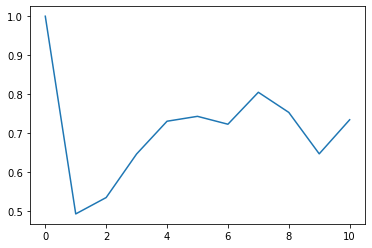

In [103]:
plt.plot(list(range(len(arr0))), cos0)

###### 画t-sne

In [68]:
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

t-SNE: 0.1 sec


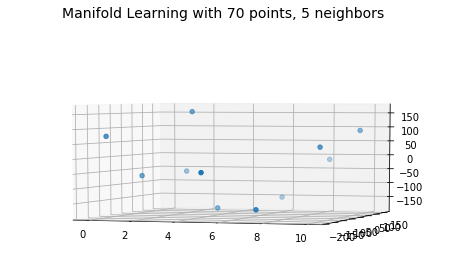

In [85]:
n_neighbors = 5
n_components = 2

t0 = time()
tsne = TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(arr0)  # 转换后的输出
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))  # 算法用时

fig = plt.figure(figsize=(8, 8))
# 创建了一个figure，标题为"Manifold Learning with 1000 points, 10 neighbors"
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (70, n_neighbors), fontsize=14)

ax = fig.add_subplot(211, projection='3d')

ax.scatter(list(range(len(arr0))), Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
ax.view_init(4, -72)  # 初始化视角
# plt.axis('tight')
plt.show()

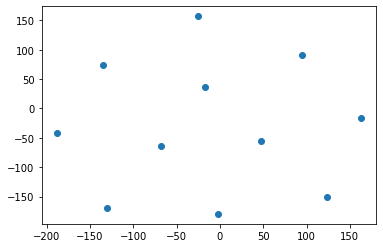

In [88]:
plt.scatter(Y[:, 0], Y[:, 1])

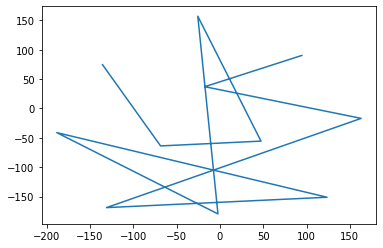

In [89]:
plt.plot(Y[:, 0], Y[:, 1])

#### 开发调试模型

In [20]:
t_steps=10000, 
stage=0
new_data_len=[] 
valid_new_len=[]
logger=None
log_dir="RDMBertTrain"
cuda=True

In [21]:
batch_size = 20
sum_loss = 0.0
sum_acc = 0.0
t_acc = 0.9
ret_acc = 0.0
init_states = torch.zeros([1, batch_size, rdm_model.hidden_dim], dtype=torch.float32).cuda()
weight = torch.tensor([2.0, 1.0], dtype=torch.float32).cuda()
loss_fn = nn.CrossEntropyLoss(weight=weight)

In [22]:
x, x_len, y = get_df_batch(0, 20)

In [24]:
seq = sent_pooler(x)
# rdm_hiddens = rdm_model(seq)
rdm_hiddens, rdm_out, rdm_cell = rdm_model(seq, x_len.tolist())
batchsize, _, _ = rdm_hiddens.shape

### 原始CM模型

In [20]:
class CM_Model_V1(nn.Module):
    def __init__(self, hidden_dim, action_num):
        super(CM_Model_V1, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_num = action_num
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_state):
        """
        rdm_state: [batchsize, hidden_dim]
        """
        batchsize, hidden_dim = rdm_state.shape
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
                rdm_state
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop

class CM_Model(nn.Module):
    def __init__(self, sentence_embedding_dim, hidden_dim, action_num):
        super(CM_Model, self).__init__()
        self.sentence_embedding_dim = sentence_embedding_dim
        self.hidden_dim = hidden_dim
        self.action_num = action_num
#         self.PoolLayer = pooling_layer(self.embedding_dim, 
#                                             self.hidden_dim)
        self.DenseLayer = nn.Linear(self.hidden_dim, 64)
        self.Classifier = nn.Linear(64, self.action_num)
        
    def forward(self, rdm_model, rl_input, rl_state):
        """
        rl_input: [batchsize, max_word_num, sentence_embedding_dim]
        rl_state: [1, batchsize, hidden_dim]
        """
        assert(rl_input.ndim==3)
        batchsize, max_word_num, embedding_dim = rl_input.shape
        rl_output, rl_new_state = rdm_model.gru_model(
                                            rl_input, 
                                            rl_state
                                        )
        rl_h1 = nn.functional.relu(
            self.DenseLayer(
#                 rl_state.reshape([len(rl_input), self.hidden_dim]) #it is not sure to take rl_state , rather than rl_output, as the feature
                rl_output.reshape(
                    [len(rl_input), self.hidden_dim]
                )
            )
        )
        stopScore = self.Classifier(rl_h1)
        isStop = stopScore.argmax(axis=1)
        return stopScore, isStop, rl_new_state

In [21]:
def TrainCMModel(sent_pooler, rdm_model, rdm_classifier, cm_model, stage, t_rw, t_steps, log_dir, logger, FLAGS, cuda=True):
    batch_size = 20
    t_acc = 0.9
    ids = np.array(range(batch_size), dtype=np.int32)
    seq_states = np.zeros([batch_size], dtype=np.int32)
    isStop = np.zeros([batch_size], dtype=np.int32)
    max_id = batch_size
    df_init_states = torch.zeros([1, batch_size, rdm_model.hidden_dim], dtype=torch.float32).cuda()
    writer = SummaryWriter(log_dir, filename_suffix="_ERD_CM_stage_%3d"%stage)
    state = df_init_states
    D = deque()
    ssq = []
    print("in RL the begining")
    rl_optim = torch.optim.Adam([{'params':cm_model.parameters(), 'lr':1e-5}])
    # get_new_len(sess, mm)
    data_ID = get_data_ID()

    if len(data_ID) % batch_size == 0: # the total number of events
            flags = int(len(data_ID) / FLAGS.batch_size)
    else:
        flags = int(len(data_ID) / FLAGS.batch_size) + 1

    rdm_hiddens_seq = []
    for i in range(flags):
        with torch.no_grad():
            x, x_len, y = get_df_batch(i, batch_size)
            seq = sent_pooler(x)
            rdm_hiddens = rdm_model(seq)
            batchsize, _, _ = rdm_hiddens.shape
            tmp_hiddens = [ rdm_hiddens[i][:x_len[i]] for i in range(batchsize)] 

            rdm_hiddens_seq.extend(tmp_hiddens)
            print("batch %d"%i)
            if len(ssq) > 0:
                ssq.extend([rdm_classifier(h) for h in tmp_hiddens])
            else:
                ssq = [rdm_classifier(h) for h in tmp_hiddens]
            torch.cuda.empty_cache()
    del rdm_hiddens, tmp_hiddens

    print(get_curtime() + " Now Start RL training ...")

    counter = 0
    sum_rw = 0.0 # sum of rewards
    data_len = get_data_len()

    while True:
    #         if counter > FLAGS.OBSERVE:
        if counter > 1000:
            if counter > t_steps:
                print("Retch The Target Steps")
                break
            rdm_state, s_ids, s_seq_states = get_RL_Train_batch_V1(D, FLAGS, batch_size, cuda)
            print("s_seq_states:", s_seq_states)
            with torch.no_grad():
                s_stopScore, s_isStop = cm_model(rdm_state)                
                rw, q_val = get_reward_0(s_isStop, s_stopScore, ssq, s_ids, s_seq_states)

            s_isStop = s_stopScore.argsort()
            for j in range(batch_size):
                if random.random() < FLAGS.random_rate:
                    s_isStop[j][int(torch.rand(2).argmax())] = 1 # 设置了一个随机的干扰。
                if seq_states[j] == data_len[s_ids[j]]:
                    s_isStop[j] = 1

            t_stopScore, t_isStop = cm_model(rdm_state)
            out_action = (t_stopScore*s_isStop.float()).sum(axis=1)
            rl_cost = torch.mean((q_val.cuda() - out_action)*(q_val.cuda() - out_action))
            rl_cost.backward()
            torch.cuda.empty_cache()
            rl_optim.step()
            print("RL Cost:", rl_cost)
            writer.add_scalar('RL Cost', rl_cost, counter - FLAGS.OBSERVE)

        ids, seq_states, max_id = get_rl_batch(ids, seq_states, max_id, 0, FLAGS)
        if counter > FLAGS.OBSERVE:
            print("step:", counter - FLAGS.OBSERVE, ", reward:", rw.mean())
            print("step:", counter - FLAGS.OBSERVE, ", reward:", q_val.mean())
            writer.add_scalar('reward', rw.mean(), counter - FLAGS.OBSERVE)
        for j in range(batch_size):
            D.append((rdm_hiddens_seq[ids[j]][seq_states[j]-1], ids[j], seq_states[j]))
            if len(D) > FLAGS.max_memory:
                D.popleft()
        counter += 1

In [22]:
cm_model = CM_Model_V1(256, 2).cuda()

In [23]:
with open("../../config.json", "r") as cr:
    dic = json.load(cr)

class adict(dict):
    ''' Attribute dictionary - a convenience data structure, similar to SimpleNamespace in python 3.3
        One can use attributes to read/write dictionary content.
    '''
    def __init__(self, *av, **kav):
        dict.__init__(self, *av, **kav)
        self.__dict__ = self

FLAGS = adict(dic)

In [24]:
del data_ID
del data_len
del data_y
del data

from dataUtils import data_ID
from dataUtils import data_len
from dataUtils import data_y
from dataUtils import data

In [27]:
cuda = True

In [112]:
x, x_len, y = get_df_batch(0, 20)
seq = sent_pooler(x)
rdm_hiddens = rdm_model(seq)
batchsize, _, _ = rdm_hiddens.shape
rdm_outs = torch.cat(
    [ rdm_hiddens[i][x_len[i]-1].unsqueeze(0) for i in range(batchsize)] 
    # a list of tensor, where the ndim of tensor is 1 and the shape of tensor is [hidden_size]
)
rdm_scores = rdm_classifier(
    rdm_outs
)
rdm_preds = rdm_scores.argmax(axis=1)
y_label = torch.tensor(y).argmax(axis=1).cuda() if cuda else torch.tensor(y).argmax(axis=1)

In [113]:
batchsize, max_seq_len, _ = rdm_hiddens.shape

stopScore, isStop = cm_model(rdm_hiddens.reshape(-1, 256))

isStop = isStop.reshape([batchsize, max_seq_len, -1])
stopScore = stopScore.reshape([batchsize, max_seq_len, -1]).softmax(axis=-1)

##### 计算奖励值
$P_{s_ts_{t+1}}^{stop} = 0.2$, $P_{s_ts_{t+1}}^{continue} = 1.0$

In [89]:
import random

In [114]:

E_rw = torch.zeros(len(x_len)).cuda()
prob = torch.ones(len(x_len)).cuda()
for j in range(len(x_len)):
    sum_rw = 0.0
    for t in range(x_len[j]):
        if random.random() < stopScore[j][t][0]:
            rw = -2.0/x_len[j]
            sum_rw += pow(gamma, t)*rw
            prob[j] *= stopScore[j][t][0]            
        else:
            if y[t][1] == 1:
                rw = 1.0
            else:
                rw = -1.0
            sum_rw += pow(gamma, t)*rw
            prob[j] *= stopScore[j][t][1]
            if random.random() > stopScore[j][t][0]*0.8:
                prob[j] *= 0.2
                continue
            else:
                prob[j] *= 0.8
                break
    E_rw[j] = prob[j]*sum_rw

In [115]:
E_rw.mean()

tensor(0.0480, device='cuda:0', grad_fn=<MeanBackward0>)

In [116]:
E_rw.mean().backward()

In [135]:
cm_model.Classifier.bias.grad

tensor([-0.1501,  0.1501], device='cuda:0')

In [124]:
cm_model.parameters

<bound method Module.parameters of CM_Model_V1(
  (DenseLayer): Linear(in_features=256, out_features=64, bias=True)
  (Classifier): Linear(in_features=64, out_features=2, bias=True)
)>

In [128]:
cm_model.DenseLayer.weight.grad[:, 2]

tensor([ 2.3243e-03, -3.7346e-03, -2.2496e-03,  2.0127e-04, -7.0226e-07,
        -1.2231e-06,  3.0092e-03,  1.0209e-04,  5.1023e-04,  5.8671e-04,
        -3.3503e-03,  2.3306e-04, -1.0836e-03,  1.2252e-04,  1.2734e-06,
         1.7792e-03, -3.6655e-04,  1.1308e-03,  1.3898e-04, -2.3393e-04,
         7.9612e-05,  1.0782e-03,  2.8988e-03, -2.0485e-03,  0.0000e+00,
         1.4991e-05, -1.3598e-03,  2.5439e-03,  0.0000e+00,  2.6299e-03,
         0.0000e+00,  7.8712e-04, -2.0296e-04,  1.1501e-03,  0.0000e+00,
        -3.3561e-06, -2.4082e-03, -3.2616e-03,  1.3546e-03, -2.5670e-03,
         2.5143e-04,  1.2142e-04,  3.6075e-03, -1.6696e-03, -3.6478e-03,
         3.9861e-04, -6.5540e-04, -2.1520e-05, -3.7279e-04, -3.0819e-03,
        -1.5073e-03, -1.4589e-03,  1.0510e-03, -8.2171e-04,  1.2041e-03,
        -2.9462e-04,  0.0000e+00,  2.3378e-03,  2.4727e-03,  2.6905e-03,
        -2.4922e-09,  1.2005e-03,  2.3503e-03, -2.8909e-03], device='cuda:0')

In [111]:
y

array([[0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0]], dtype=int32)

In [109]:
random.randint(0, 10)

9

In [110]:
TrainCMModel(sent_pooler, rdm_model, rdm_classifier, cm_model, 0, 0.5, 20000, "ERD/", None, FLAGS, cuda=True)

in RL the begining
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8


KeyboardInterrupt: 

In [102]:
from dataUtils import valid_data_ID
from dataUtils import valid_data_len
from dataUtils import valid_data_y

In [116]:
rst = get_new_len(sent_pooler, rdm_model, cm_model, FLAGS, cuda)

NameError: name 'new_len' is not defined

In [117]:
log_dir = os.path.join(sys.path[0], "ERD/")